# Practical Session 7 - Active contour using level sets
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\norm}[1]{\|#1\|}$



In the level set formalism, the evolution of some curve $ (\gamma(t))_{t=0}^1 $
is computed by evolving the
zero level of a function $\phi : \RR^2 \rightarrow \RR $
$$ \enscond{\gamma(s)}{ s \in [0,1] } = \enscond{x \in \RR^2}{\phi(x)=0}. $$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from scipy import ndimage
import pylab
from skimage.color import rgb2gray 

# Functions

In [2]:
def plot_levelset(Z, level=0, f=[]):
    """
    f is supposed to be of the same shape as Z
    f, Z : (nr,nc)
    Plot contour Z, on he same plot as the original image f, and print level of value 0 in red.
    """
    if len(f) == 0:
        f = np.copy(Z)
        
    n,p = np.shape(Z)
    X,Y = np.meshgrid(np.arange(0,p),np.arange(0,n))
    plt.contour(X, Y, Z,[level],linewidths=2, colors="red")
    imgplot = plt.imshow(f, interpolation='nearest')
    imgplot.set_cmap('gray')
    pylab.axis('off')

# Importation of images

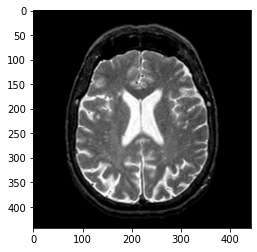

In [3]:
anchor = mpimg.imread('Images/anchor.jpg') 
cortex = (mpimg.imread('Images/cortex.bmp'))
I = cortex
I_gray = rgb2gray(I)
nr,nc= I_gray.shape
plt.imshow(I_gray,cmap='gray')

# Mean curvature motion

The mean curvature motion corresponds to the minimizing flow of the
length of the curve
$$ \int_0^1 \norm{\gamma'(s)} d s. $$



It is implemeted in a level set formalism by a familly $\phi_t$ of
level set function parameterized by an artificial time $t \geq 0$, that
satisfies the following PDE
$$ \pd{\phi_t}{t} = -G(\phi_t)
  \qwhereq G(\phi) = -\norm{\nabla \phi} \text{div}
      \pa{  \frac{\nabla \phi}{\norm{\nabla \phi}} }  $$
and where $\nabla \phi_t(x) \in \RR^2$ is the spatial gradient.


This flow is computed using a gradient descent
$\phi^{(0)} = \phi_0$ and
$$ \phi^{(\ell+1)} = \phi^{(\ell)} - \tau G(\phi^{(\ell)}), $$
where $\tau>0$ is small enough time step.

And maximum time of the evolution $0 \leq t \leq t_{\max}$.

**Instructions: Code mean curvature motion. \
This first method allows you to implement important functions you will need in Geodesic Active Contour part, and code the core of the full algorithm. \
But here, as the algorithm does not take into account the image during the minimization process, you consider that your initial $\phi^0$ depends on $I_0$.**


In [4]:
def div(phi): 
    return np.gradient(phi[0])[0] + np.gradient(phi[1])[1] 

def gradient_norm(phi): 
    return np.sqrt((np.gradient(phi)[0])**2 + (np.gradient(phi)[1])**2)  

def G(phi): 
    return - gradient_norm(phi) * div(np.gradient(phi) / (gradient_norm(phi) + 1e-10)) # to avoid dividing by zero. 

#---------- ---------- ---------- ---------- ---------- ---------- ---------- 

def mean_curv(phi0, tau, Tmax): 
    '''
    phi0 : your initial shape, size (nr,nc) 
    tau : time step size, > 0, be careful to not have a too big time step !
    Tmax : maximum time of evolution
    ------
    return : phi 
    '''
    n = int(Tmax // tau) 
    phi = phi0 
    for j in range(n): 
        phi = phi - tau * G(phi) 
    
    return phi 

## Application

In [5]:
nr = 200
nc = 300
Y,X = np.meshgrid(np.arange(1,nc+1), np.arange(1,nr+1))

r = nr/4.
c = np.asarray([nc,nc])/4.
phi1 = (np.maximum(abs(X-c[0]), abs(Y-c[1]))-r)


r = nr/4.
c = np.asarray([nc,nc])/2.1
phi2 = np.sqrt((X-c[0])**2 + (Y-c[1])**2) - r

phi3 = np.minimum(phi1, phi2)

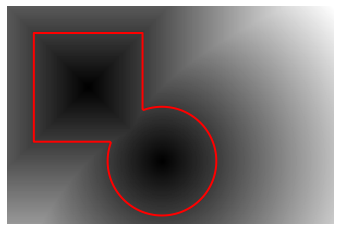

In [6]:
plot_levelset(phi3)

**Instructions: Execute your algorithm on the "image" $\phi^3$ given above.\
Then change initial $\phi^0$ and see what happens.**

In [7]:
# Play with parameters
tau = 0.1
Tmax = 10 

phi = mean_curv(phi3, tau, Tmax) 

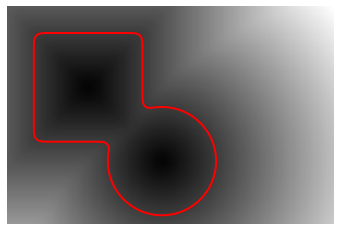

In [8]:
plot_levelset(phi)

When we increase Tmax, the edge of the red curve becomes more blurry. 

# Geodesic Active Contour
Geodesic active contours compute local minimum of a weighted geodesic
distance that attract the curve toward the features of the background
image.

Given a background image $I_0$ to segment, one needs to compute
an edge-stopping function $W$.
It should be small in area of high gradient, and high in area of small gradient.


We use here
$$ W(x) = \alpha + \frac{\beta}{\epsilon + d_0(x) }
      \qwhereq d_0(x) = \norm{\nabla I_0(x)} $$




The geodesic active contour minimizes a weighted length of curve
$$ \underset{\gamma}{min} \int_0^1 \norm{\gamma'(s)} W(\gamma(s)) d s $$


The level set implementation of the gradient descent of this energy reads
$$ \pd{\phi_t}{t} = G(\phi_t)
  \qwhereq G(\phi) = -\norm{\nabla \phi} \text{div}\pa{
          W \frac{\nabla \phi}{\norm{\nabla \phi}}
  } $$


This is implemented using a gradient descent scheme.
$$ \phi^{(\ell+1)} = \phi^{(\ell)} - \tau G(\phi^{(\ell)}), $$
where $\tau>0$ is small enough.




**Instructions: Define an initial $\phi^0$. You can plot it, together with your image I_gray, with plot_levels function.\
Here your $\phi^0$ does not depend on your image $I_0$ !**

In [9]:
nr,nc = I_gray.shape 
Y,X = np.meshgrid(np.arange(1,nc+1), np.arange(1,nr+1)) 

r = np.min(np.array([nr,nc])) / 2.5
c = np.array([nr,nc]) / 2 
phi0 = np.sqrt((X - c[0])**2 + (Y - c[1])**2) - r 

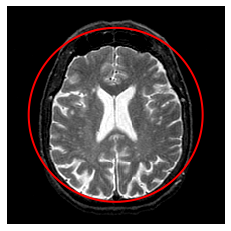

In [10]:
plot_levelset(phi0, 0, I_gray)

**Compute $W$, and plot it to see how it looks.**

In [11]:
def gradient_norm(phi): 
    return np.sqrt((np.gradient(phi)[0])**2 + (np.gradient(phi)[1])**2)  

def compute_W(image, alpha, beta, epsilon): 
    return alpha + (beta / (epsilon + gradient_norm(image))) 

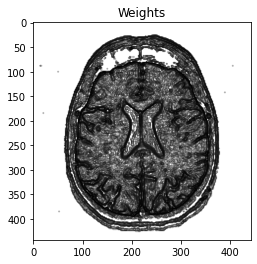

In [12]:
alpha   = 1e-2 
beta    = 1 
epsilon = 1e-2 
W = compute_W(I_gray, alpha, beta, epsilon) 

plt.figure()
plt.imshow(W,cmap='gray')
plt.title('Weights')
plt.show()

**Instructions: code here the gradient descent algorithm to estimate geodesic active contour.**

In [13]:
def div(phi): 
    return np.gradient(phi[0])[0] + np.gradient(phi[1])[1] 

def gradient_norm(phi): 
    return np.sqrt((np.gradient(phi)[0])**2 + (np.gradient(phi)[1])**2)  

def compute_G(phi, W): 
    return - gradient_norm(phi) * div(W * np.gradient(phi) / (gradient_norm(phi) + 1e-10)) # to avoid dividing by zero. 

#---------- ---------- ---------- ---------- ---------- ---------- ---------- 

def geo_curv(phi0, tau, Tmax, I0, W):
    '''
    phi0 : your initial shape, size (nr,nc)
    tau : time step size, > 0, be careful to not have a too big time step !
    Tmax : maximum time of evolution
    I0 : your image to segment
    W : edge-stopping matrix, size (nr,nc)
    ------
    returns phi, contour matrix (nr,nc)
    '''
    n = int(Tmax // tau) 
    phi = phi0 
    for j in range(n): 
        phi = phi - tau * compute_G(phi, W) 
    
    return phi 

## Application
Depending on the image you want to segment, and your initial $\phi^0$, you may need a huge number of iterations to see significative modifications of your contour.

In [14]:
# Play with parameters
tau = 0.01 
Tmax = 4 

phi = geo_curv(phi0, tau, Tmax, I_gray, W) 

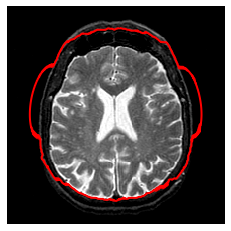

In [15]:
plot_levelset(phi, 0, I_gray) 

## Conclusion

**What's your conclusion on these methods ?** \
There exists other variants of active contours with level sets.

The geodesic active contour method helps us to determine the contour of the background. However, it is very hard to find a perfect contour. 